# Forecasting Experiments

Try different forecasting methods on 2 representative sample data, try to see whether we can find a method works for both time series in order to forecast well.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [10]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

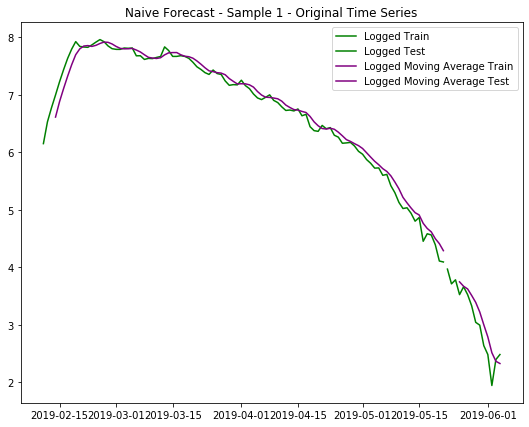

In [17]:
plt.figure(figsize=(9,7))
plt.plot(ts_log_train1.index, ts_log_train1, label='Logged Train', color='green')
plt.plot(ts_log_test1.index, ts_log_test1, label='Logged Test', color='green')
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Logged Moving Average Train', color='purple')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, label='Logged Moving Average Test', color='purple')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 - Original Time Series")
plt.show()

## Logged Time Series

* Without using logged moving average but just use the logged original time series.
  * Because logged time series has no null value and keeps the original time series pattern.
  * It's in the same scale as logged moving average, which makes the comparison between RMSE values easier.
* Compare between different forecasting methods, to see which one works better for the original time series.

### Approach 1 - Weighted Naive Forecast

* As we can see logged ts is in dropping trend. So we can assume testing data is w*latest_window of training data.
  * Latest window of training data has the same size as the testing data, and it's the closest to the testing data.
  * w is the weight. We can assume there is a linear regression relationshio between testing data and the latest window of the training data.
    * The reason I chose w=2/3 here is because the latest window of training data is between [4, 6], while the testing data seems between [2, 4].
    * Also tried a few other weights and this one works better.

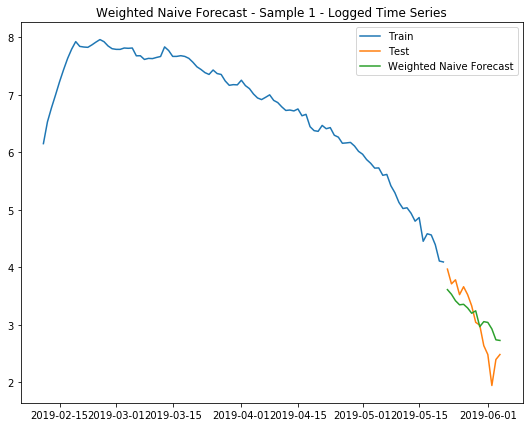

RMSE: 0.39276349567356206


In [26]:
train = ts_log_train1.copy()
test = ts_log_test1.copy()
w = 2/3
y_pred = train.iloc[-len(test):]*w
y_pred.index = test.index

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_pred.index, y_pred, label='Weighted Naive Forecast')
plt.legend(loc='best')
plt.title("Weighted Naive Forecast - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

### Approach 2 - Exponetial Smoothing

* The idea is, the weights will decrease from the latest to the oldest data
* `Yt+1 = α*Yt + α(1-α)*Yt-1 + α(1-α)(1-α)*Yt-2 + ... + α*pow(1-α, n)*Yt-n`
  * α is in [0,1] range

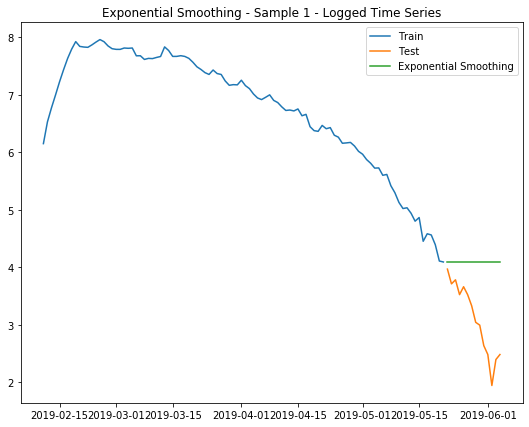

RMSE: 1.1580401582283357


In [170]:
title = 'Exponential Smoothing'

train = ts_log_train1.copy()
test = ts_log_test1.copy()

model_fit = SimpleExpSmoothing(np.array(train)).fit(smoothing_level=0.99,optimized=False)
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

#### Note

* The exponential smoothing appears like a horizontal line might be because it puts too much weights on the last time point. 
* Larger `α` (smoothing level), smaller RMSE, but also means higher weights on latest time points. So overall looks like constant over the time.


### Approach 3 - Holt's Linear Trend

This method helps to decompose the time series into trend, seasonality and residual. It applies exponential smoothing to both Level data and Trend data.
* Level data - the average value in the series
* Each equation here is exponential smoothing
* Additive method - Forecast result = Trent Equation + Level Equation
* Multiplication method - Forecast result = Trent Equation*Level Equation
* This approach is neither additive nor multiplication, but linear

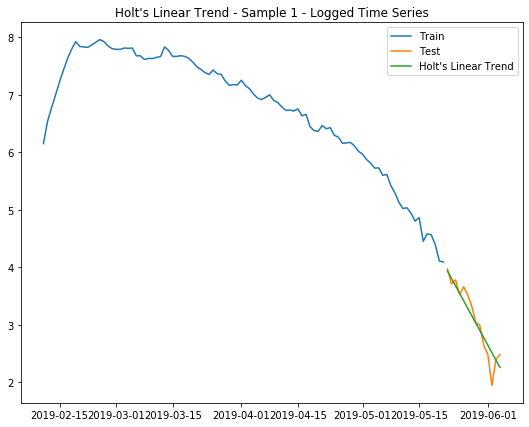

RMSE: 0.2059903933404052


In [171]:
title = "Holt's Linear Trend"

train = ts_log_train1.copy()
test = ts_log_test1.copy()

model_fit = Holt(np.asarray(train)).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

### Approach 4 - Holt-Winters

* It considers both trend and seasonality.
* Each equation here is exponential smoothing.
* Additive method - Forecast result = Trent Equation + Level Equation + Seasonality Equation
* Multiplication method - Forecast result = Trent Equation*Level Equation*Seasonality Equation

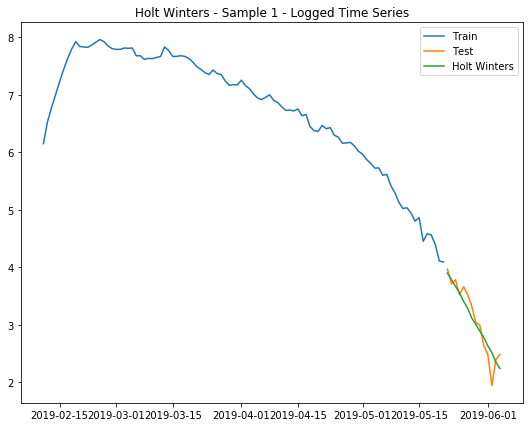

RMSE: 0.21263784045977638


In [172]:
title = "Holt Winters"

train = ts_log_train1.copy()
test = ts_log_test1.copy()

model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=6, trend='mul',
                                 seasonal='add', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

### Approach 5 - Seasonal ARIMA (SARIMA)

* ARIMA is trying to tell the correlations between the data. Seasonal ARIMA takes into account the seasonality
* p: The number of lag observations included in the model, also called the lag order. It is The lag value where the PACF chart crosses the upper confidence interval for the first time
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [173]:
title = "SARIMA"

train = ts_log_train1.copy()
test = ts_log_test1.copy()

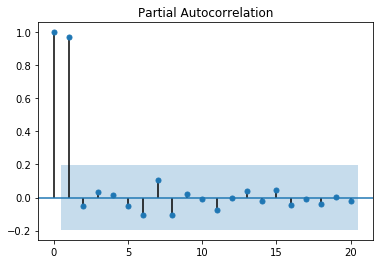

In [174]:
plot_pacf(train, lags=20);

In [124]:
# check time series cross validation
tscv = TimeSeriesSplit(n_splits=20)

ct = 0
for cv_train_index, cv_test_index in tscv.split(train.values):
    print("TRAIN:", cv_train_index, "TEST:", cv_test_index)
    ct += 1
    if ct ==4:
        break

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24 25 26 27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] TEST: [28 29 30 31]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31] TEST: [32 33 34 35]


In [139]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

bestAIC = np.inf
best_cvAIC = np.inf
bestParam = None
best_cvParam = None

X = train.values

# grid search with cross validation
for param in pdq:
    for cv_train_index, cv_test_index in tscv.split(train.values):
        X_train, X_test = X[cv_train_index], X[cv_test_index]
        try:
            model = sm.tsa.statespace.SARIMAX(X_train,
                                              order=param,
                                              seasonal_order=(0,1,1,7))
            results = model.fit()
            #if current run of AIC is better than the best one so far, overwrite it
            if results.aic < bestAIC:
                bestAIC = results.aic
                bestParam = param

            # apply the best order on testig data
            best_model = sm.tsa.statespace.SARIMAX(X_train,
                                                   order=param,
                                                   seasonal_order=(0,1,1,7))
            results = best_model.fit()
            if results.aic < best_cvAIC:
                best_cvAIC = results.aic
                best_cvParam = bestParam
        except:
            pass
    
print('the best AIC, the best CV AIC and order are:',bestAIC,best_cvAIC,bestParam)

the best AIC, the best CV AIC and order are: -202.53726566491986 -202.53726566491986 (2, 1, 1)


In [144]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

bestAIC = np.inf
bestParam = None
best_itrAIC = np.inf
best_itrParam = None

X_train = train.values[:-len(test)]
X_test = train.values[-len(test):]
print(len(X_train), len(X_test))

# grid search without cross validation
for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(X_train,
                                          order=param,
                                          seasonal_order=(0,1,1,7))
        results = model.fit()
        #if current run of AIC is better than the best one so far, overwrite it
        if results.aic < bestAIC:
            bestAIC = results.aic
            bestParam = param

        # apply the best order on testig data
        best_model = sm.tsa.statespace.SARIMAX(X_train,
                                          order=param,
                                          seasonal_order=(0,1,1,7))
        results = best_model.fit()
        if results.aic < best_itrAIC:
            best_itrAIC = results.aic
            best_itrParam = bestParam
    except:
        pass
    
print('the best AIC, the best iteration AIC and order are:',bestAIC,best_itrAIC,bestParam)

86 14
the best AIC, the best iteration AIC and order are: -185.0679606954137 -185.0679606954137 (2, 1, 2)


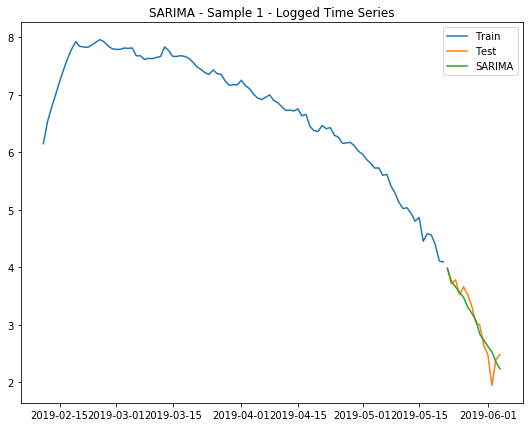

RMSE: 0.20267586907114943


In [175]:
model_fit = SARIMAX(train, order=(1, 1, 1),seasonal_order=(0,1,1,7)).fit()  # order means (p,d,q) for ARIMA
y_pred = model_fit.predict(start="2019-05-22", end="2019-06-04", dynamic=True)

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

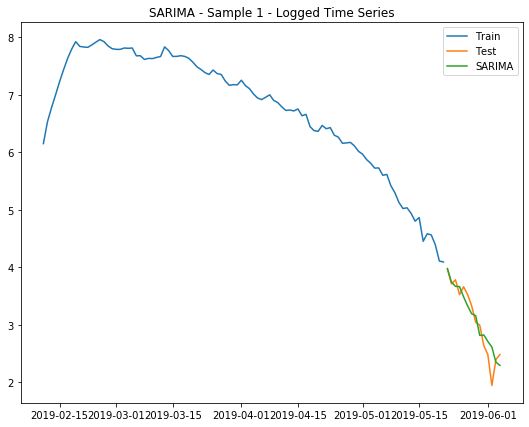

RMSE: 0.2299894771677894


In [176]:
model_fit = SARIMAX(train, order=(2,1,2),seasonal_order=(0,1,1,7)).fit()  # order means (p,d,q) for ARIMA
y_pred = model_fit.predict(start="2019-05-22", end="2019-06-04", dynamic=True)

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 1 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

#### Note:

* For SARIMA, this time series works better when there is seasonal order.
* Looking at the pattern of the whole time series, the latest values are decreasing. Grid search with corss validation (CV) doesn't work better than grid search without CV.
  * This is because earlier data as training could help less to the testing data.
* However optimized order from Grid Search doesn't give better result as order (1,1,1) for this time series.

#### Try Some winning methods on Sample 2

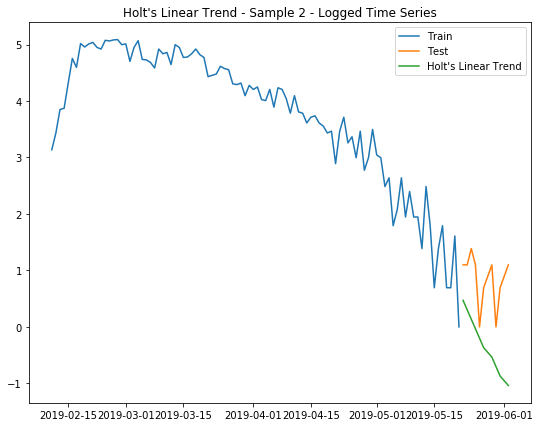

RMSE: 1.2333461268319634


In [177]:
title = "Holt's Linear Trend"

train = ts_log_train2.copy()
test = ts_log_test2.copy()

model_fit = Holt(np.asarray(train)).fit()
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 2 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

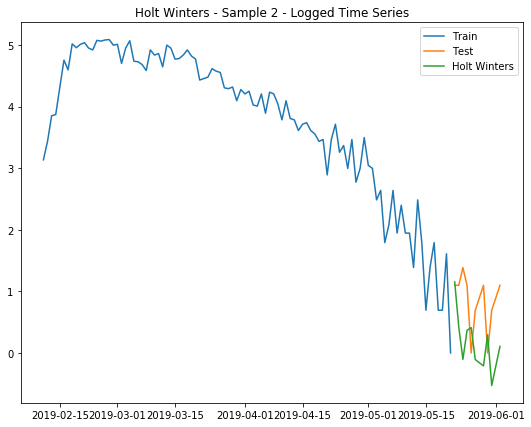

RMSE: 0.9119812345633174


In [178]:
title = "Holt Winters"

train = ts_log_train2.copy()
test = ts_log_test2.copy()

model_fit = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=9, trend='add',
                                 seasonal='add', damped=False).fit()
y_pred = model_fit.forecast(len(test))

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 2 - Logged Time Series")
plt.show()

rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

In [216]:
title = "SARIMA"

train = ts_log_train2.copy()
test = ts_log_test2.copy()

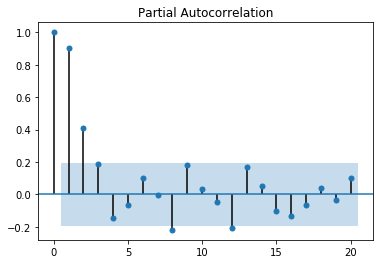

In [232]:
plot_pacf(train, lags=20);

In [169]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

bestAIC = np.inf
bestParam = None
best_itrAIC = np.inf
best_itrParam = None

X_train = train.values[:-len(test)]
X_test = train.values[-len(test):]
print(len(X_train), len(X_test))

# grid search without cross validation
for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(X_train,
                                          order=param,
                                          seasonal_order=(0,1,1,7))
        results = model.fit()
        #if current run of AIC is better than the best one so far, overwrite it
        if results.aic < bestAIC:
            bestAIC = results.aic
            bestParam = param

        # apply the best order on testig data
        best_model = sm.tsa.statespace.SARIMAX(X_train,
                                          order=param,
                                          seasonal_order=(0,1,1,7))
        results = best_model.fit()
        if results.aic < best_itrAIC:
            best_itrAIC = results.aic
            best_itrParam = bestParam
    except:
        pass
    
print('the best AIC, the best iteration AIC and order are:',bestAIC,best_itrAIC,bestParam)

90 10
the best AIC, the best iteration AIC and order are: 0.9348053572010215 0.9348053572010215 (0, 2, 2)


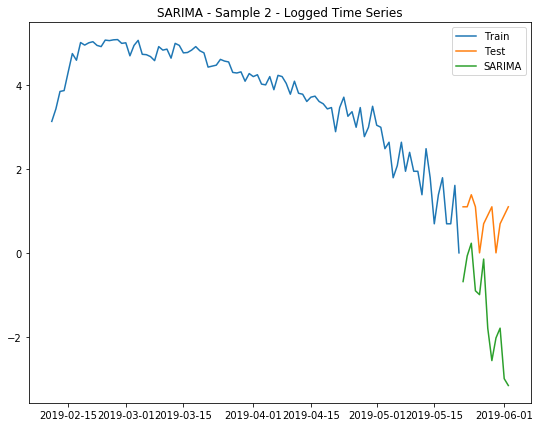

RMSE: 2.3142443280908362


In [223]:
model_fit = SARIMAX(train, order=(0,2,2),seasonal_order=(0,1,1,7)).fit()  # order means (p,d,q) for ARIMA
y_pred = model_fit.predict(start="2019-05-22", end="2019-06-02", dynamic=True)

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_pred.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 2 - Logged Time Series")
plt.show()

# Need to make sure test and y_pred have matched dates
del y_pred['2019-05-28']
del y_pred['2019-06-01']
rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

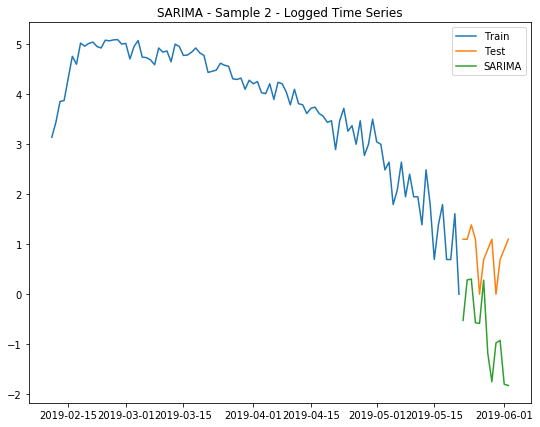

RMSE: 1.6721962207117054


In [237]:
model_fit = SARIMAX(train, order=(2,1,1),seasonal_order=(0,1,1,7)).fit()  # order means (p,d,q) for ARIMA
y_pred = model_fit.predict(start="2019-05-22", end="2019-06-02", dynamic=True)

plt.figure(figsize=(9,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_pred.index, y_pred, label=title)
plt.legend(loc='best')
plt.title(title + " - Sample 2 - Logged Time Series")
plt.show()

# Need to make sure test and y_pred have matched dates
del y_pred['2019-05-28']
del y_pred['2019-06-01']
rmse = sqrt(mean_squared_error(test, y_pred))
print('RMSE:', rmse)

#### Note

* One of the drawback of SARIMA here is, it defines start and end time, and if testing data has some date is missing, you need to remove some records from y_pred to make sure they have matched dates, in order to calculate RMSE.
* In Sample 2, the testing data is no longer as linear as Sample 1, models such as Holt Winters which can capture both trend and seasonality might be better.

## Logged Moving Average